<a href="https://colab.research.google.com/github/Kimeteor309/Financial-big-data-analysis/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90_week9%E4%BD%9C%E6%A5%AD_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97_LSTM%E3%80%81Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 在 Colab 上使用中文字體

In [1]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-11-07 05:19:49--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.180.101, 64.233.180.139, 64.233.180.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.180.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-11-07 05:19:49--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.180.132, 2607:f8b0:4004:c21::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.180.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   103MB/s    in 0.2s    

2024-11-07 05:19:

# 取得股價資料

In [78]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# 將民國年轉換為西元年
def convert_to_gregorian(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)  # 民國年轉換為西元年
    return f'{year}/{month}/{day}'

# 從台灣證券交易所 API 獲取每日收盤價
def get_twse_data(stock_id, date):
    url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock_id}"
    response = requests.get(url)
    data = response.json()

    # 解析 JSON 並轉換為 DataFrame
    columns = data['fields']
    rows = data['data']
    df = pd.DataFrame(rows, columns=columns)

    # 將日期轉換為西元年
    df['日期'] = df['日期'].apply(convert_to_gregorian)
    df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')  # 指定西元年格式

    # 只保留你需要的欄位，並重新命名為英文字段
    df = df[['日期', '開盤價', '最高價', '最低價', '收盤價', '成交股數']].copy()
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    # 將數值欄位轉為數字類型，並去除逗號
    df['Open'] = pd.to_numeric(df['Open'].str.replace(',', ''))
    df['High'] = pd.to_numeric(df['High'].str.replace(',', ''))
    df['Low'] = pd.to_numeric(df['Low'].str.replace(',', ''))
    df['Close'] = pd.to_numeric(df['Close'].str.replace(',', ''))
    df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''))

    return df

# 獲取一段日期範圍內的股價資料
def get_data_range(stock_id, start_year, end_year, start_month, end_month):
    all_data = pd.DataFrame()  # 用於存放所有年份和月份的數據

    # 迭代年份
    for year in range(start_year, end_year + 1):
        # 迭代月份
        for month in range(start_month, end_month + 1):
            # 日期格式：YYYYMMDD，只需要指定月份的第一天
            date = f"{year}{month:02d}01"
            # 獲取指定月份的數據
            df_month = get_twse_data(stock_id, date)
            # 合併當前月份數據到所有數據中
            all_data = pd.concat([all_data, df_month], ignore_index=True)  # 合併時確保索引正確

    return all_data

# 取得台積電從4月至9月的股價資料
stock_id = '2330'  # 台積電股票代號
data = get_data_range(stock_id, 2020, 2023, 1, 12)

# 顯示資料
data

,Date,Open,High,Low,Close,Volume
0,2020-01-02,332.5,339.0,332.5,339.0,33282120
1,2020-01-03,344.0,345.0,335.5,339.5,42023268
2,2020-01-06,333.0,334.5,332.0,332.0,45677057
3,2020-01-07,332.5,333.0,326.5,329.5,51746181
4,2020-01-08,325.0,333.0,325.0,329.5,37913748
...,...,...,...,...,...,...
969,2023-12-25,582.0,585.0,580.0,581.0,9994163
970,2023-12-26,583.0,586.0,582.0,586.0,17033926
971,2023-12-27,587.0,592.0,586.0,592.0,34750958
972,2023-12-28,592.0,593.0,589.0,593.0,27152352


# 作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# 使用MinMaxScaler來標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# 定義窗口大小（此處為20天）
lookback = 20

# 創建一個方法來創建數據集
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:i+window_size, 0])  # 取過去20天的數據
        y.append(data[i + window_size, 0])  # 預測第21天的收盤價
    return np.array(X), np.array(y)

# 創建訓練集和測試集
X, y = create_dataset(scaled_data, lookback)

# 切分訓練集和測試集（80%訓練，20%測試）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 重塑數據以適應LSTM輸入要求：樣本數，時間步長，特徵數
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, X_test.shape)

(762, 20, 1) (191, 20, 1)


In [43]:
from tensorflow.keras.layers import Dropout, Bidirectional

# 建立改進後的 LSTM 模型
model = Sequential()

# 添加雙向LSTM層，並增加Dropout層防止過擬合
model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# 添加第二層LSTM和Dropout
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
model.add(Dropout(0.2))

# 添加全連接層
model.add(Dense(units=1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0999 - val_loss: 0.0075
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0062 - val_loss: 0.0011
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0031 - val_loss: 9.4082e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0031 - val_loss: 8.0171e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - val_loss: 8.2442e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029 - val_loss: 7.7766e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024 - val_loss: 7.6724e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 7.5596e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/ste

In [44]:
# 預測測試集
predictions = model.predict(X_test)

# 反標準化預測結果和真實結果
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 計算預測誤差
mae = mean_absolute_error(real_prices, predicted_prices)
print(f'Mean Absolute Error: {mae}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Mean Absolute Error: 11.734055751345936


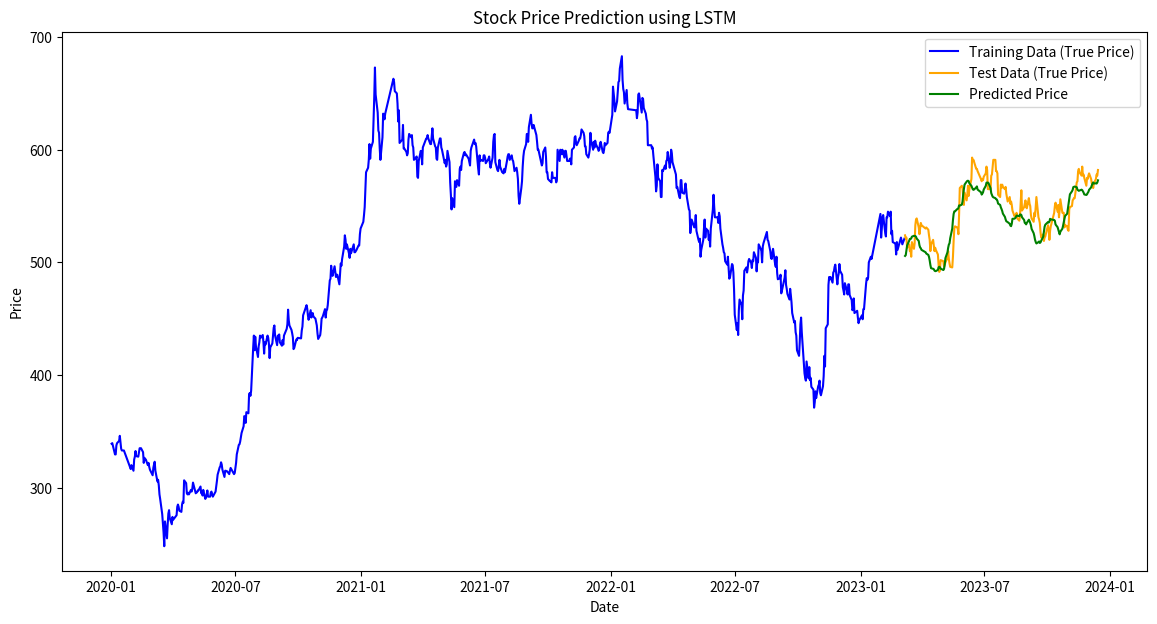

In [45]:
# 視覺化結果
# 創建日期範圍（根據你的數據日期）
dates = pd.to_datetime(data['Date'])
train_size = len(X_train)  # 訓練集大小

# 訓練集的日期和價格
train_dates = dates[:train_size]
train_prices = data['Close'][:train_size]

# 測試集的日期和價格
test_dates = dates[train_size:train_size + len(predicted_prices)]
test_prices = data['Close'][train_size:train_size + len(predicted_prices)]

# 開始繪圖
plt.figure(figsize=(14, 5))
plt.plot(train_dates, train_prices, label='Training Data (True Price)', color='blue')
plt.plot(test_dates, test_prices, label='Test Data (True Price)', color='orange')
plt.plot(test_dates, predicted_prices, label='Predicted Price', color='green')

plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

# 顯示圖表
plt.show()

# 作業2：使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

In [79]:
window_size = 20  # 時間窗口大小
train_ratio = 0.8

# 使用MinMaxScaler來標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# 生成數據樣本
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])  # 預測下一天
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, window_size)

# 分割訓練與測試集
train_size = int(len(X) * train_ratio)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(X_train.shape, X_test.shape)

(763, 20, 1) (191, 20, 1)


In [84]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# 定義 Temporal Fusion Transformer (TFT) 模型
class TemporalFusionTransformer(Model):
    def __init__(self, window_size, hidden_dim=64, num_heads=4):
        super(TemporalFusionTransformer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.window_size = window_size

        # 時間嵌入層
        self.input_layer = layers.Input(shape=(window_size, 1))

        # LSTM 用於處理時間依賴
        self.lstm = layers.LSTM(hidden_dim, return_sequences=True)

        # Transformer 多頭注意力層
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)

        # 前饋神經網絡
        self.dense1 = layers.Dense(hidden_dim, activation="relu")
        self.dense2 = layers.Dense(1)  # 預測未來一天

    def call(self, inputs):
        x = self.lstm(inputs)

        # 應用注意力機制
        attn_output = self.attention(x, x)

        # 跳過連接
        x = layers.Add()([x, attn_output])

        # 前饋網絡
        x = self.dense1(x)
        x = layers.GlobalAveragePooling1D()(x)
        output = self.dense2(x)

        return output

# 建立 TFT 模型
tft_model = TemporalFusionTransformer(window_size)
tft_model.compile(optimizer='adam', loss='mean_squared_error')

In [85]:
# 訓練模型
history = tft_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1911 - val_loss: 0.0103
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0109 - val_loss: 0.0080
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0057 - val_loss: 0.0076
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0038 - val_loss: 0.0067
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 0.0065
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0035 - val_loss: 0.0067
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

In [94]:
# 預測並反標準化
predicted_prices = tft_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 計算漲跌方向的準確率
predicted_directions = np.where(predicted_prices[1:] > predicted_prices[:-1], 1, 0)
real_directions = np.where(real_prices[1:] > real_prices[:-1], 1, 0)
accuracy = np.mean(predicted_directions == real_directions)
print(f'漲跌方向準確率: {accuracy * 100:.2f}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
漲跌方向準確率: 47.89%


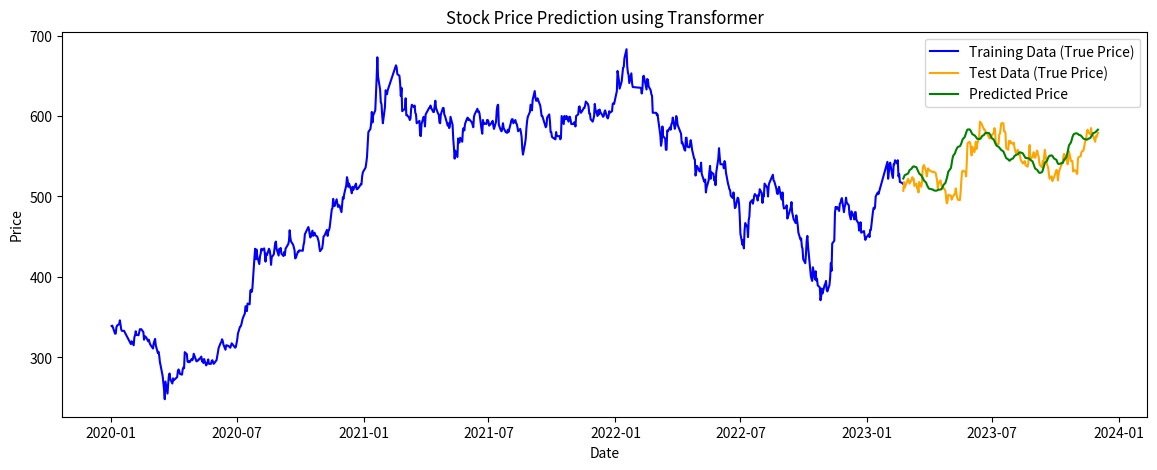

In [95]:
import matplotlib.pyplot as plt

# 視覺化結果
# 創建日期範圍（根據你的數據日期）
dates = pd.to_datetime(data['Date'])
train_size = len(X_train)  # 訓練集大小

# 訓練集的日期和價格
train_dates = dates[:train_size]
train_prices = data['Close'][:train_size]

# 測試集的日期和價格
test_dates = dates[train_size:train_size + len(predicted_prices)]
test_prices = data['Close'][train_size:train_size + len(predicted_prices)]

# 開始繪圖
plt.figure(figsize=(14, 5))
plt.plot(train_dates, train_prices, label='Training Data (True Price)', color='blue')
plt.plot(test_dates, test_prices, label='Test Data (True Price)', color='orange')
plt.plot(test_dates, predicted_prices, label='Predicted Price', color='green')

plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

# 顯示圖表
plt.show()